# GP05 GeoPandas
GeoPandas Full Documentation: https://geopandas.org/en/stable/docs.html

Spatial Reference: https://spatialreference.org/
___
## 8. Overlay Analysis
* Spatial overlays.
* Creation of dataset from intersection between two data.
* Creation of new features from various data types such as Points, Lines and Polygons. 
* Set operations/overlays: Union; Intersection; Difference
* The overlay function to determine the set of all individual geometries from overlaying two input GeoDataFrames: **.overlay()**
* Calculation of a circle area (buffer) around a point: **.buffer()**

In [1]:
# Library import + Data Load
import geopandas as gpd
import matplotlib.pyplot as plt
from pyproj import Proj

# GeoPandas Built-in Datasets: Check Availabilty
gpd.datasets.available

['naturalearth_cities', 'naturalearth_lowres', 'nybb']

In [2]:
# Load GeoPandas built-in datasets from 'naturalearth_cities' (for world capitals) and 'naturalearth_lowres' (world map)
w = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
cap = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))
cap.head()

C:\Users\likre\AppData\Local\Temp\ipykernel_85096\2859606998.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  w = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
C:\Users\likre\AppData\Local\Temp\ipykernel_85096\2859606998.py:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_cities' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  cap = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))


,name,geometry
0,Vatican City,POINT (12.45339 41.90328)
1,San Marino,POINT (12.44177 43.93610)
2,Vaduz,POINT (9.51667 47.13372)
3,Lobamba,POINT (31.20000 -26.46667)
4,Luxembourg,POINT (6.13000 49.61166)


<Axes: >

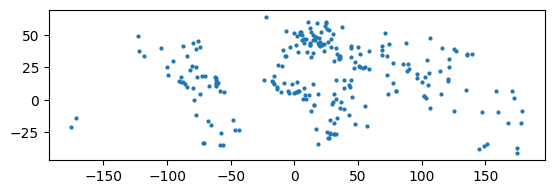

In [3]:
# Quick plots of the world capitals
cap.plot(markersize=4)

<Axes: >

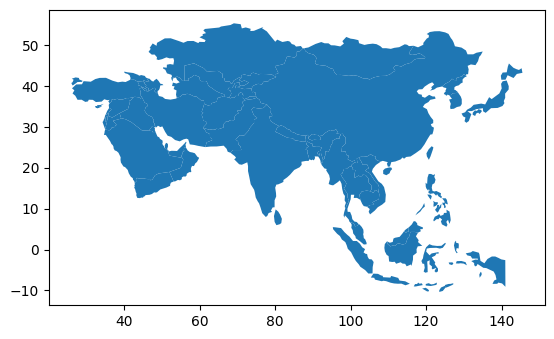

In [4]:
# Select the Asia continent
a = w[w['continent'] == "Asia"]
a = a[['geometry', 'name']]
a.plot()

In [5]:
# CRS Projection to metres for distance measurements
a = a.to_crs(epsg=3395) 
cap = cap.to_crs(epsg=3395)
a.crs

<Projected CRS: EPSG:3395>
Name: WGS 84 / World Mercator
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World between 80°S and 84°N.
- bounds: (-180.0, -80.0, 180.0, 84.0)
Coordinate Operation:
- name: World Mercator
- method: Mercator (variant A)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: >

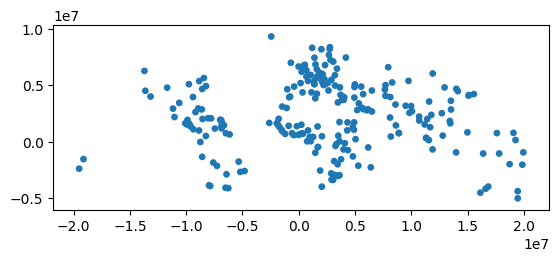

In [6]:
# The overlay function. 
# Example: Use GeoDataFrames of both Asia and world capitals to define areas of 200km radius surrouding a capital (i.e. A 300 km buffer zone)
cap['geometry']= cap.buffer(300000)
cap.plot()

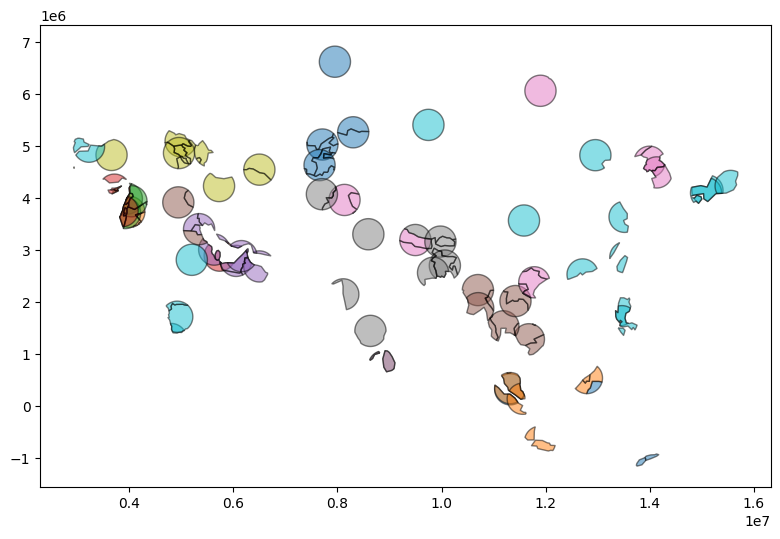

In [7]:
# Set overlay: Intersection
ac = gpd.overlay(a, cap, how='intersection')
ac.plot(figsize=(12,6), alpha=0.5, edgecolor='k', cmap='tab10');

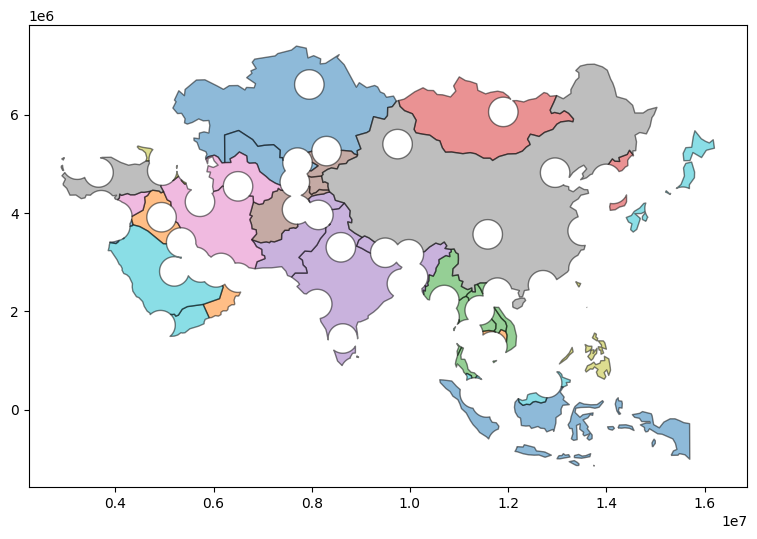

In [8]:
# Set overlay: Difference
# The portions of countries away from those capitals (peripheries)
ap = gpd.overlay(a, cap, how='difference')
ap.plot(figsize=(12,6), alpha=0.5, edgecolor='k', cmap='tab10');

___
## 9. Nearest Neighbour Analysis
* To determine the nearest neighbour of the object of interest with spatial data.


**Example: Nearest Neighbourhood Analysis with Bike Sharing dataset from Chicago City**
* The dataset contains of two separate files (Bike stations and randomly generated points).
* Onjective: Determination of the nearest station from any randomly generated point provided in the second dataset. The randomnly generated points serve to simulate real situations.

In [9]:
# Relevant library import + Data Load (Bike stations)
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import folium 
from shapely.ops import nearest_points
from shapely.geometry import LineString

s = pd.read_csv("localdata/stations.csv")
s.head()

,id,name,dpcapacity,xcoord,ycoord
0,5,State St & Harrison St,19,-87.627739,41.873958
1,13,Wilton Ave & Diversey Pkwy,19,-87.652681,41.932500
2,14,Morgan St & 18th St,15,-87.651073,41.858086
3,15,Racine Ave & 19th St,15,-87.656471,41.856453
4,16,Wood St & North Ave,15,-87.672516,41.910329


In [6]:
# Data Load (random points)
p = pd.read_csv("localdata/points.csv")
p.head()

,id,xcoord,ycoord
0,1,-87.675992,41.969792
1,2,-87.676702,41.956395
2,3,-87.601501,41.805379
3,4,-87.616656,41.858263
4,5,-87.706869,41.963010


In [10]:
# Create a function to convert both datasets into Geodataframes
def gdf(df, x="xcoord", y="ycoord"):
    return gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df[x], df[y]), crs=('epsg:4326'))

sgdf=gdf(s)
pgdf=gdf(p)

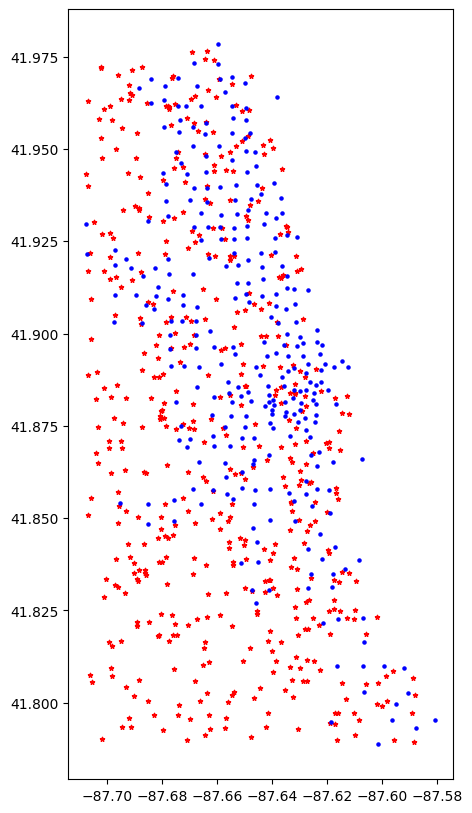

In [11]:
# Plot to display bike stations and random points
fig, ax = plt.subplots(figsize=(12,10))
pgdf.plot(ax=ax, color="red", marker= "*", markersize=10)
sgdf.plot(ax=ax, color="blue", markersize=5)
plt.show()

### Nearest Neighbour Methods:
* Geopandas geoseries method: **.unary_union** --> Return a geometry containing the union of all geometries in a GeoSeries.
* Shapely.ops function: **nearest_points()** --> Calculate the nearest geometries.
* Geopandas geoseries method: **.set_geometry** --> Set the geometry of the GeoDataFrame.

In [34]:
# Create a function to calculate the nearest distances between generated points and destinations
def n(row, d, val, col="geometry"):
    dest_unary = d["geometry"].unary_union
    nearest_geom = nearest_points(row[col], dest_unary)
    match_geom = d.loc[d.geometry == nearest_geom[1]]
    match_value = match_geom[val].to_numpy()[0]
    return match_value

# The .apply() method to pass the arguments into the function.
pgdf["nearest_geom"] = pgdf.apply(n, d=sgdf, val="geometry", axis=1)
pgdf["nearest_station"] = pgdf.apply(n, d=sgdf, val="name", axis=1)

pgdf.head()

,id,xcoord,ycoord,geometry,nearest_geom,nearest_station
0,1,-87.675992,41.969792,POINT (-87.67599 41.96979),POINT (-87.67424 41.96909),Ravenswood Ave & Lawrence Ave
1,2,-87.676702,41.956395,POINT (-87.67670 41.95640),POINT (-87.67926 41.95593),Lincoln Ave & Belle Plaine Ave
2,3,-87.601501,41.805379,POINT (-87.60150 41.80538),POINT (-87.59938 41.80983),Greenwood Ave & 47th St
3,4,-87.616656,41.858263,POINT (-87.61666 41.85826),POINT (-87.61941 41.85761),Calumet Ave & 18th St
4,5,-87.706869,41.963010,POINT (-87.70687 41.96301),POINT (-87.68849 41.96655),Western Ave & Leland Ave


In [35]:
# Connecting the points to their closest stations via a line: LineString
pgdf['line'] = pgdf.apply(lambda row: LineString([row['geometry'], row['nearest_geom']]), axis=1)
pgdf.head()

,id,xcoord,ycoord,geometry,nearest_geom,nearest_station,line
0,1,-87.675992,41.969792,POINT (-87.67599 41.96979),POINT (-87.67424 41.96909),Ravenswood Ave & Lawrence Ave,"LINESTRING (-87.67599 41.96979, -87.67424 41.9..."
1,2,-87.676702,41.956395,POINT (-87.67670 41.95640),POINT (-87.67926 41.95593),Lincoln Ave & Belle Plaine Ave,"LINESTRING (-87.67670 41.95640, -87.67926 41.9..."
2,3,-87.601501,41.805379,POINT (-87.60150 41.80538),POINT (-87.59938 41.80983),Greenwood Ave & 47th St,"LINESTRING (-87.60150 41.80538, -87.59938 41.8..."
3,4,-87.616656,41.858263,POINT (-87.61666 41.85826),POINT (-87.61941 41.85761),Calumet Ave & 18th St,"LINESTRING (-87.61666 41.85826, -87.61941 41.8..."
4,5,-87.706869,41.963010,POINT (-87.70687 41.96301),POINT (-87.68849 41.96655),Western Ave & Leland Ave,"LINESTRING (-87.70687 41.96301, -87.68849 41.9..."


In [43]:
# Set the geometry of the Geodataframe to the LineString geometry
lgdf = pgdf[["id", "nearest_station", "line"]].set_geometry('line')
lgdf.crs = crs = 'epsg:4326'

pgdf.drop(["nearest_geom", "line"], axis=1, inplace=True)
pgdf.head()

,id,xcoord,ycoord,geometry,nearest_station
0,1,-87.675992,41.969792,POINT (-87.67599 41.96979),Ravenswood Ave & Lawrence Ave
1,2,-87.676702,41.956395,POINT (-87.67670 41.95640),Lincoln Ave & Belle Plaine Ave
2,3,-87.601501,41.805379,POINT (-87.60150 41.80538),Greenwood Ave & 47th St
3,4,-87.616656,41.858263,POINT (-87.61666 41.85826),Calumet Ave & 18th St
4,5,-87.706869,41.963010,POINT (-87.70687 41.96301),Western Ave & Leland Ave


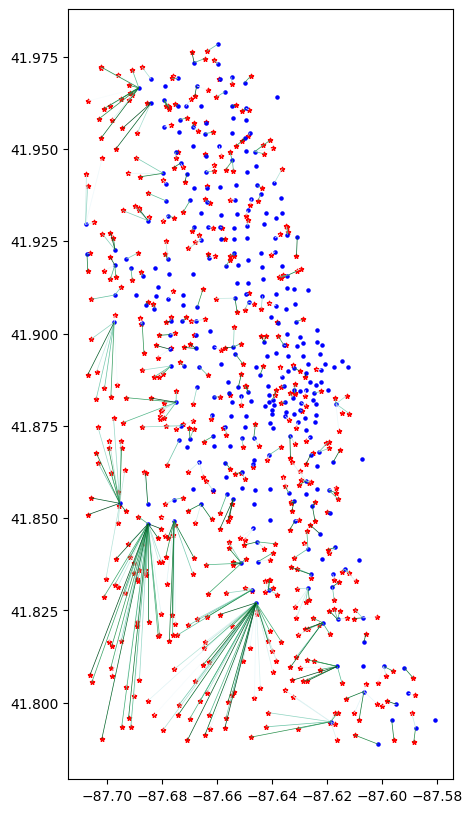

In [60]:
# Plot to display three datasets: pgdf, sgdf & lgdf
fig, ax = plt.subplots(figsize=(12,10))
pgdf.plot(ax=ax, color="red", marker= "*", markersize=10)
sgdf.plot(ax=ax, color="blue", markersize=5)
lgdf.plot(ax=ax, linewidth=0.5, cmap='BuGn')
# lgdf.plot(ax=ax, linewidth=0.6, cmap='BuGn', edgecolor='0.5', vmin=0, vmax=1)
plt.show()

In [92]:
# Overlaying the three datasets on top of an interactive data visualisation map via folium (to be elaborated later).
# Folium map built-in titleset: https://python-visualization.github.io/folium/latest/user_guide/raster_layers/tiles.html
m = folium.Map(location=[41.87, -87.65], zoom_start = 11.8, tiles="OpenStreetMap")
sloc = zip(sgdf.ycoord, sgdf.xcoord)
ploc = zip(pgdf.ycoord, pgdf.xcoord)
for x in sloc:
    folium.CircleMarker(location=x, color="blue", radius=2).add_to(m)
for x in ploc:
    folium.CircleMarker(location=x, color="red", radius=2).add_to(m)
folium.GeoJson(lgdf, style_function=lambda feature: {"color": "black", "weight": 1, "dashArray": "5, 8"}).add_to(m)
m.save("gp05map.html")
m

___